# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/d/danieltm/ExaTrkX/heptrkx-gnn-tracking/notebooks'

In [56]:
# System imports
import os
import sys
from pprint import pprint as pp
from time import time as tt

# External imports
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
# from nb_utils import (load_config_file, load_config_dir, load_summaries,
#                       plot_train_history, get_test_data_loader,
#                       compute_metrics, plot_metrics, draw_sample_xy, draw_triplets_xy, get_dataset)

from nb_utils import *

In [57]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [3]:
# Load by config file
config_file = '../configs/tripgnn_med.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

In [129]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/ExaTrkX/triplet_results/checkpoints_med_000')

In [130]:
ls $result_base

agnn01/  agnn02/  agnn04/  agnn05/


In [131]:
result_name = 'agnn05'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pp(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/triplet_data/hitgraphs_med_000',
          'n_train': 3584,
          'n_valid': 16,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3.0},
 'model': {'hidden_dim': 64,
           'input_dim': 7,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 3,
           'name': 'tripgnn'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 20,
                                      'factor': 0.5,
                                      'start_epoch': 10},
                                     {'end_epoch': 40,
                                      'factor': 0.1,
                                      'start_epoch': 20},
                                     {'end_epoch': 50,
                                      'factor': 0.05,
            

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.00100,0.020699,2782.736238,109.803647,0,123.969112,0.013152,0.993957,0.548102
1,0.00100,0.011707,2792.145096,110.559170,1,123.583214,0.011425,0.995079,0.538318
2,0.00100,0.011588,2813.584270,111.649464,2,123.438901,0.011396,0.994768,0.581799
3,0.00100,0.006386,2849.938530,113.562274,3,123.774484,0.002985,0.998949,0.573545
4,0.00100,0.002631,2887.009272,114.925207,4,123.709242,0.002576,0.999114,0.597771
...,...,...,...,...,...,...,...,...,...
59,0.00001,0.000874,3513.943863,132.893736,59,123.711236,0.001020,0.999606,0.533703
60,0.00001,0.000875,3514.084859,132.901124,60,123.187232,0.001027,0.999608,0.540091
61,0.00001,0.000875,3514.184617,132.908376,61,123.647474,0.001001,0.999613,0.540638
62,0.00001,0.000875,3514.300192,132.916572,62,123.639041,0.000987,0.999624,0.537962


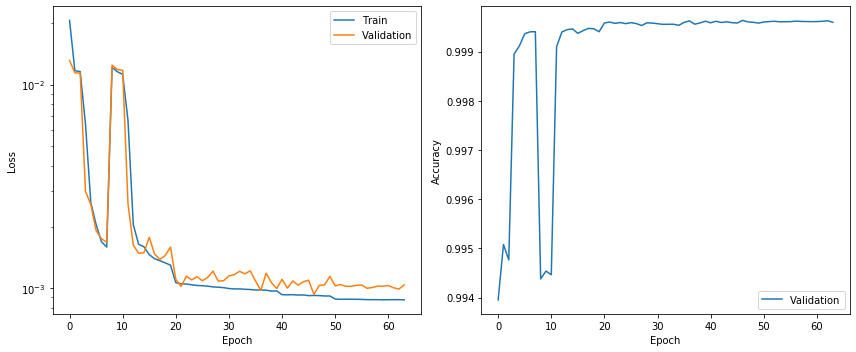

In [132]:
plot_train_history(summaries, loss_yscale='log')

Text(0, 0.5, 'Learning rate')

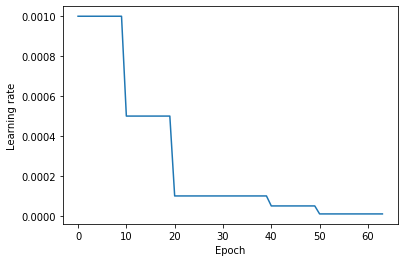

In [133]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [134]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
46,0.00005,0.000918,3509.984023,132.692655,46,123.601753,0.000929,0.999632,0.534762


In [135]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=142, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=213, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    

## Evaluate the model on the test dataset

In [136]:
# Load the test dataset
n_test = 16
test_loader = get_test_data_loader(config, n_test=n_test)

In [137]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 45.9 s, sys: 303 ms, total: 46.2 s
Wall time: 14 s


In [138]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9997
Precision: 0.9944
Recall:    0.9986


In [139]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9997
Precision: 0.9978
Recall:    0.9966


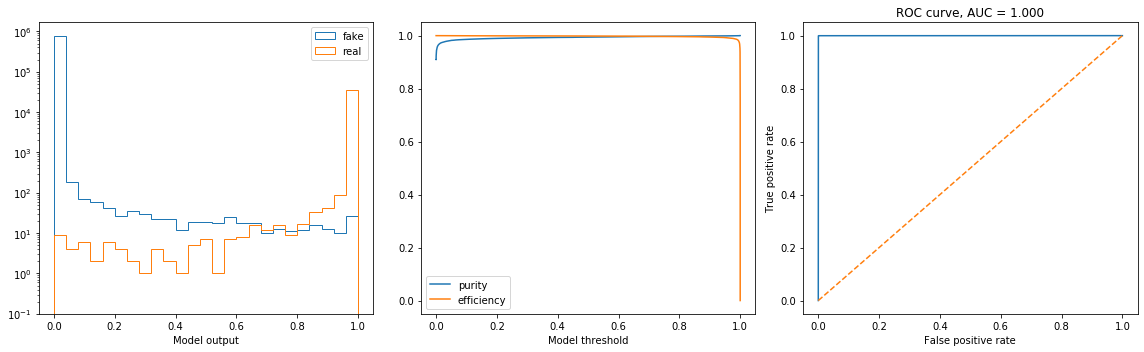

In [140]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [141]:
n_phi_sections = 4
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000., 1000., np.pi / n_phi_sections, 1000., 1])

Find a small event, if required

In [142]:
for i in range(n_test):
    g = test_loader.dataset[i]
    e = g.edge_index.numpy()
    x = g.x.numpy() * feature_scale
    y = g.y.numpy()
    o = test_preds[i].numpy()
    print(i, " with triplet number: ", len(y), " and doublet number: ", len(x))

0  with triplet number:  39093  and doublet number:  11692
1  with triplet number:  44702  and doublet number:  12717
2  with triplet number:  83411  and doublet number:  19884
3  with triplet number:  36831  and doublet number:  10933
4  with triplet number:  38301  and doublet number:  11725
5  with triplet number:  33330  and doublet number:  10508
6  with triplet number:  76245  and doublet number:  18213
7  with triplet number:  31568  and doublet number:  9862
8  with triplet number:  85767  and doublet number:  19771
9  with triplet number:  24843  and doublet number:  8697
10  with triplet number:  97103  and doublet number:  21611
11  with triplet number:  39480  and doublet number:  11691
12  with triplet number:  37273  and doublet number:  11022
13  with triplet number:  48687  and doublet number:  13910
14  with triplet number:  32159  and doublet number:  10184
15  with triplet number:  46034  and doublet number:  12919


In [143]:
i=9
g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

In [80]:
x_o = np.concatenate([x[e[0,:]], x[e[1,:]], np.array([o]).T], axis=1)

In [81]:
x_o.shape

(24843, 15)

### Scatter plot of triplet score vs product of doublet scores

This would be a naive and quick way to create tracks from doublets - by multiplying the scores of pairs of doublets to find the most likely channels. We see that this is a good first-order approximation. However, there is a group of misidentifications.

Text(0.5, 1.0, 'As above-left, with true-false regions')

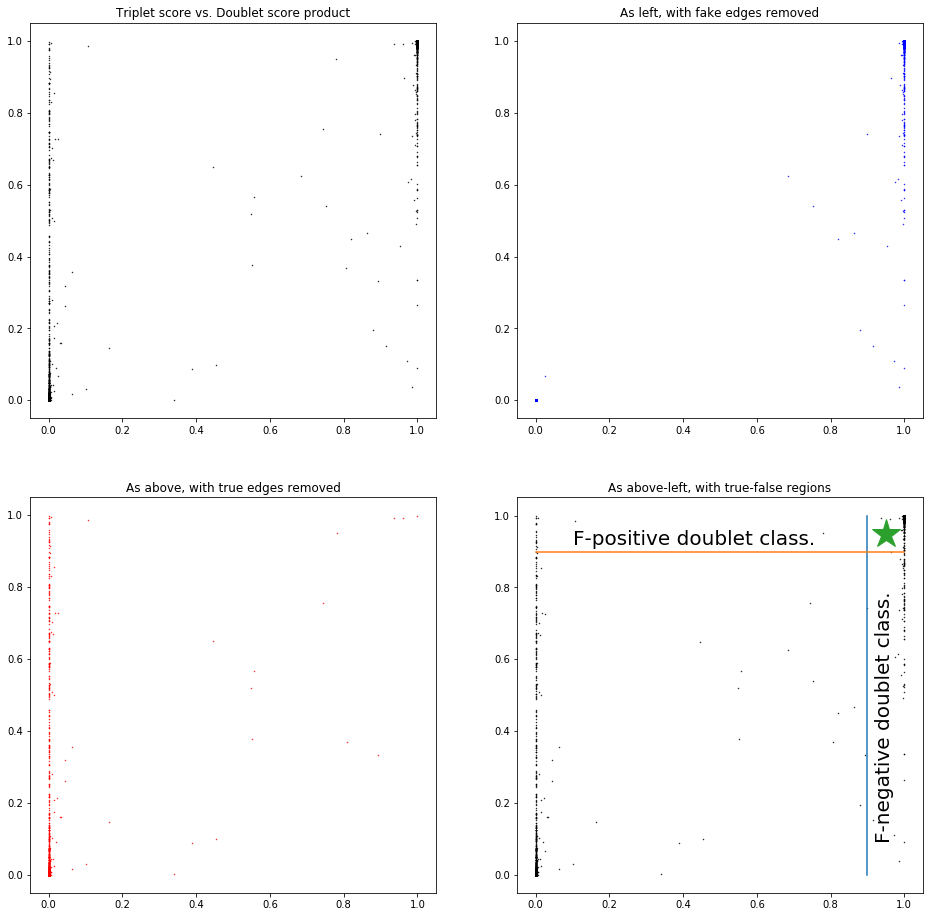

In [82]:
fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2,2, figsize=(16,16))
ax0.scatter(x_o[:,14],x_o[:,6]*x_o[:,13], s=0.2, c='k')
ax0.set_title("Triplet score vs. Doublet score product")
ax1.scatter(x_o[:,14]*y,x_o[:,6]*x_o[:,13]*y, s=0.2, c='b')
ax1.set_title("As left, with fake edges removed")
ax2.scatter(x_o[:,14]*(1-y),x_o[:,6]*x_o[:,13]*(1-y), s=0.2, c='r')
ax2.set_title("As above, with true edges removed")
x1, y1, x2, y2 = [0.9, 0.9], [0,1], [0,1], [0.9,0.9]
ax3.scatter(x_o[:,14],x_o[:,6]*x_o[:,13], s=0.2, c='k')
ax3.plot(x1, y1, x2, y2)
ax3.text(0.92,0.1,"F-negative doublet class.", size=20, rotation=90)
ax3.text(0.1,0.92,"F-positive doublet class.", size=20)
ax3.plot(0.95,0.95,'*',markerSize=30)
ax3.set_title("As above-left, with true-false regions")

We quantify the naive prediction accuracy. There are two slightly different approaches: the first is to directly multiply the two scores, and select all above 0.81 (i.e. 0.9 * 0.9). The other is to cut first at 0.9, then multiply.

In [145]:
model_accuracy = ((o > 0.9) == (y > 0.9)).sum() / len(y)
naive_accuracy_1 = ((x[e[0,:],6]*x[e[1,:],6] > 0.8) == (y > 0.9)).sum() / len(y)
naive_accuracy_2 = (((x[e[0,:],6]>0.8) * (x[e[1,:],6]>0.8)) == (y > 0.9)).sum() / len(y)
print("Triplet classifier accuracy: %.4f, naive_1 accuracy: %.4f, naive_2 accuracy: %.6f" % (model_accuracy, naive_accuracy_1, naive_accuracy_2))

Triplet classifier accuracy: 0.9996, naive_1 accuracy: 0.9954, naive_2 accuracy: 0.995210


## Colouring by Multiplicity

6.062677383422852


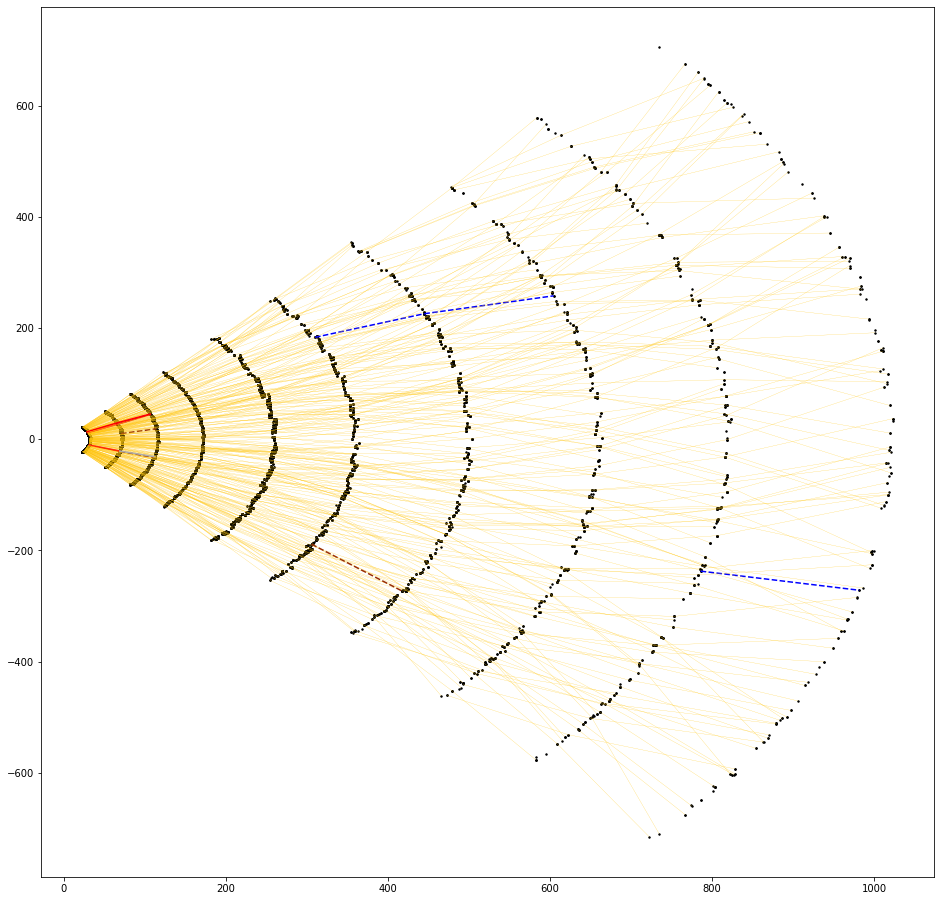

In [144]:
tic = tt()
draw_triplets_tf_mul_xy(x, e, o, y, cut=0.9, lineWidth=0.2);
print(tt()-tic)

Given the above plot of all edges, we would like to know if the triplet classifier outperforms the doublet classifier. We take all true cases (t-positive and t-negative) and ask if the doublet score would have predicted these incorrectly. These are labelled "overperform" and coloured black (solid for t-positive, dotted for t-negative, and dot-dashed for ambiguous cases that could be easily resolved with a naive algorithm). We also take all false cases (f-positive and f-negative) and ask if the doublet score would have predicted these correctly. These are labelled "underperform" and coloured red (solid for f-positive and dotted for f-negative). 

Overperforms by:  123 , underperforms by:  0 .
1.16127347946167


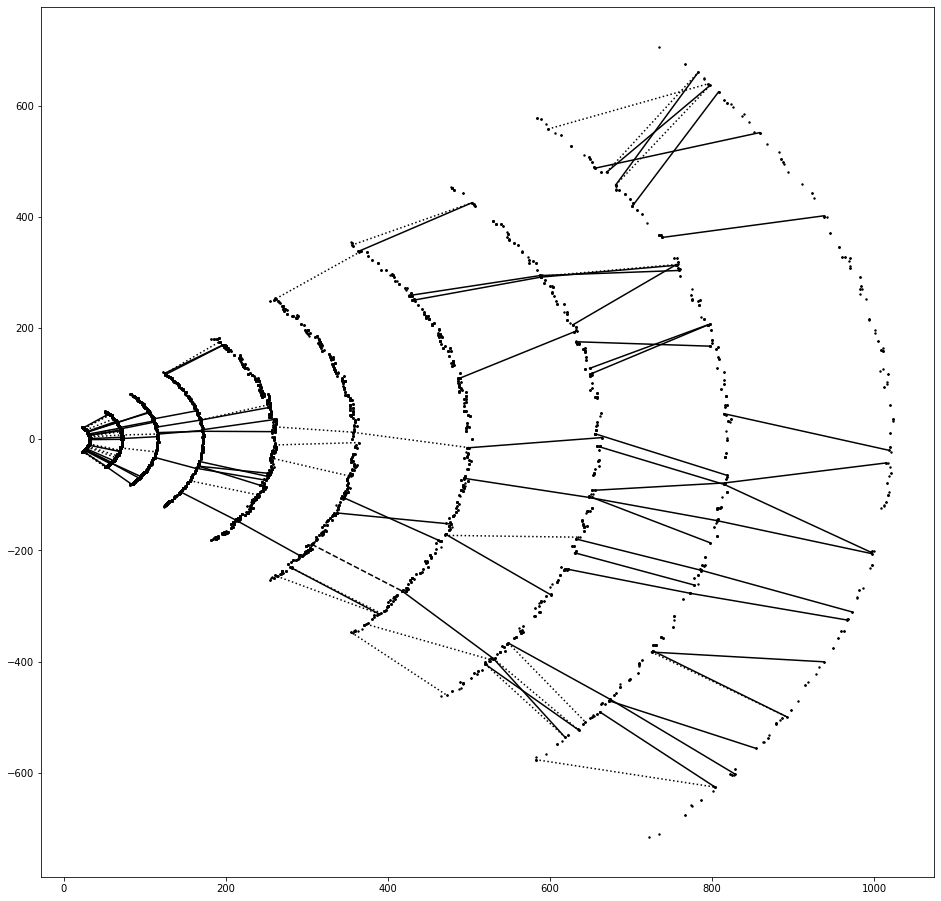

In [146]:
tic = tt()
draw_triplets_xy_antiscore_cut(x, e, o, y, cut=0.93);
print(tt()-tic)

In [48]:
tf = tf_multiplicity(x, e, o, y, cut=0.9);

In [56]:
np.where(tf[:,0]>1)

(array([3203, 3213, 3241, ..., 8564, 8566, 8573]),)

In [59]:
tf[3203]

array([ 2.,  0., 10.,  0.])

## Writing data files

In [97]:
n_test = 10
test_loader = get_test_data_loader(config, n_test=n_test)
test_preds, test_targets = trainer.predict(test_loader)

In [30]:
len(test_preds)

10

In [37]:
len(test_preds[1])

4263

In [44]:
g = test_loader.dataset[0]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

In [46]:
len(o)

53970

In [53]:
e[:,0]

array([5512,  347])

In [66]:
x[e[0,1000]],x[e[1,1000]]

(array([ 7.16653913e+01,  7.68787138e-01, -2.99602002e+01,  1.15002297e+02,
         7.83129915e-01, -1.07385002e+02,  6.83567996e-05]),
 array([ 3.19514759e+01,  7.61692056e-01, -2.77606994e+01,  7.16653913e+01,
         7.68787138e-01, -2.99602002e+01,  3.50703089e-03]))

In [58]:
y[0]

1.0

In [60]:
o[0]

0.99949276

## Resolve Multiplicities

## Play Area

In [225]:
for edge, pred, label in zip(e.T, o, y):
    print(edge, pred, label)

[4413    0] 0.99855894 1.0
[4413   51] 0.0014309598 0.0
[4413  206] 0.0011559377 0.0
[4413 1290] 0.0014689749 0.0
[4413 1447] 0.0014754322 0.0
[4413 2116] 0.001506932 0.0
[4413 2706] 0.0015007671 0.0
[4413 3635] 0.001484851 0.0
[4413 4282] 0.0014699096 0.0
[4413 4293] 0.0014858687 0.0
[4414    0] 0.025007974 0.0
[4414   51] 0.9999882 1.0
[4414  206] 0.9999869 1.0
[4414 1290] 0.9999889 1.0
[4414 1447] 0.9999883 1.0
[4414 2116] 0.9999887 1.0
[4414 2706] 0.9999883 1.0
[4414 3635] 0.99998784 1.0
[4414 4282] 0.9999888 1.0
[4414 4293] 0.99998844 1.0
[4415    0] 0.028466882 0.0
[4415   51] 0.99999034 1.0
[4415  206] 0.9999893 1.0
[4415 1290] 0.99999094 1.0
[4415 1447] 0.99999046 1.0
[4415 2116] 0.9999907 1.0
[4415 2706] 0.99999046 1.0
[4415 3635] 0.99999 1.0
[4415 4282] 0.9999908 1.0
[4415 4293] 0.99999046 1.0
[4416    0] 0.040429942 0.0
[4416   51] 0.9999871 1.0
[4416  206] 0.9999857 1.0
[4416 1290] 0.99998796 1.0
[4416 1447] 0.99998724 1.0
[4416 2116] 0.9999876 1.0
[4416 2706] 0.99998724 1.

KeyboardInterrupt: 

In [227]:
e[:,11], y[11]

(array([4414,   51]), 1.0)

In [228]:
e[:,12], y[12]

(array([4414,  206]), 1.0)

In [241]:
x[e[1,11:25]][:,0:3]

array([[ 3.21661159e+01, -6.62018321e-01,  1.46059003e+01],
       [ 3.21509391e+01, -6.59828906e-01,  3.39672007e+01],
       [ 3.25034149e+01, -6.36423340e-01, -2.79307012e+01],
       [ 3.21121030e+01, -6.54098621e-01,  5.28681986e+01],
       [ 3.27361003e+01, -6.70806831e-01, -4.82694991e+01],
       [ 3.22709642e+01, -6.76555092e-01,  5.72388002e-01],
       [ 3.27514224e+01, -6.72874437e-01,  1.02052003e+02],
       [ 3.25354449e+01, -6.41548141e-01, -1.35108000e+01],
       [ 3.26920636e+01, -6.64745294e-01, -4.06264990e-02],
       [ 3.21126580e+01, -6.54181668e-01,  2.30308007e+01],
       [ 3.21661159e+01, -6.62018321e-01,  1.46059003e+01],
       [ 3.21509391e+01, -6.59828906e-01,  3.39672007e+01],
       [ 3.25034149e+01, -6.36423340e-01, -2.79307012e+01],
       [ 3.21121030e+01, -6.54098621e-01,  5.28681986e+01]])

array([ 3.21509391e+01, -6.59828906e-01,  3.39672007e+01,  7.14494586e+01,
       -6.53282149e-01,  5.24136014e+01,  1.73804245e-03])

In [35]:
list = torch.arange(30)

In [30]:
list.split(4)

(tensor([0, 1, 2, 3]),
 tensor([4, 5, 6, 7]),
 tensor([ 8,  9, 10, 11]),
 tensor([12, 13, 14, 15]),
 tensor([16, 17, 18, 19]),
 tensor([20, 21, 22, 23]),
 tensor([24, 25, 26, 27]),
 tensor([28, 29]))

In [41]:
np.array_split(list,4)[3].numpy()

array([23, 24, 25, 26, 27, 28, 29])